Exercise 3

STEP 1 - import your drive into colab session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will use tensorflow 1

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


NOTE= make sure it installs keras 2.2.4. 
If keras 2.2.4 doesn't install the first time. run the cell again

In [ ]:
!pip3 install keras==2.2.4

STEP 2 - Do the necessary imports

In [ ]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Add, Multiply
from keras.losses import mse, binary_crossentropy
import keras.backend as K
import numpy as np
from google.colab import output


STEP 3
1.   Save your P5js app to a dropbox folder
2.   Right click and select 'copy dropbox link'
3.   Use the copied link with the code below. You need to delete everything after the .tar extension



In [ ]:
#get the dataset

#replace with your own dropbox link.
!wget https://www.dropbox.com/s/3zfed5lrqqqp0j1/line7.tar

output.clear()

STEP 4 - untar (decompress) the files to the images folder

In [ ]:
#untar
!mkdir imgs #mak the images folder  
!tar -xvf  'line7.tar' -C '/content/imgs'
output.clear()


STEP 5 - Process the images converting everything to B&W and adding them to a numpy array

In [ ]:
#necessary imports
import os 
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
from tqdm import tqdm
from PIL import Image

#image to numpy array

img_data = []

#We iterate over the imgs folder, reshape the images to (28x28x1)
#and save them to the img_data array

for img in tqdm(os.listdir('/content/imgs')):
    currentImage= '/content/imgs/' + img
    img_array = cv2.imread(currentImage)
    gray = cv2. cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    img_data.append(gray) 
img_data = np.array(img_data)

print(img_data[0].shape) #print the shape

100%|██████████| 999/999 [00:00<00:00, 11056.17it/s]

(28, 28, 1)


STEP 6 - set values for our network 

In [ ]:
#NUMBER OF DIMENSIONS IN THE LATENT SPACE
latent_dims = 768

Step 7 - Create the VAE decoder Network

In [ ]:
from IPython.core.display import clear_output
encoder_in = Input(shape=(28,28,1))  

encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same',name = 'c11', input_shape=(28,28,1))(encoder_in)
encoder_l1 = BatchNormalization(name = '1b1')(encoder_l1)
encoder_l1 = LeakyReLU(0.2,name = '1r1')(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same',name = 'c12')(encoder_l1)
encoder_l1 = BatchNormalization(name = 'b12')(encoder_l1)
encoder_l1 = LeakyReLU(0.2,name = 'r12')(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same',name = 'c13')(encoder_l1)
encoder_l2 = BatchNormalization(name = 'b13')(encoder_l2)
encoder_l2 = LeakyReLU(0.2,name = 'r13')(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same',name = 'c14')(encoder_l2)
encoder_l3 = BatchNormalization(name = 'b14')(encoder_l3)
encoder_l3 = LeakyReLU(0.2,name = 'r14')(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same',name = 'c15')(encoder_l3)
encoder_l4 = BatchNormalization(name = 'b15')(encoder_l4)
encoder_l4 = LeakyReLU(0.2,name = 'r15')(encoder_l4)

flatten = Flatten(name = 'r125')(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization(name = 'br15')(encoder_dense)
encoder_out = LeakyReLU(0.2,name = 'r1115')(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z)
encoder.summary()
clear_output()

Step 8 - Create the VAE decoder Network

In [ ]:
decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization(name = 'b1'))
decoder.add(LeakyReLU(0.2,name = 'r1'))

decoder.add(Dense(2048))
decoder.add(BatchNormalization(name = 'b2'))
decoder.add(LeakyReLU(0.2,name = 'r2'))

decoder.add(Reshape(target_shape=(2,2,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same',name = 'c1'))
decoder.add(BatchNormalization(name = 'b3'))
decoder.add(LeakyReLU(0.2,name = 'r3'))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=3, padding='same',name = 'c2'))
decoder.add(BatchNormalization(name = 'b4'))
decoder.add(LeakyReLU(0.2,name = 'r4'))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same',name = 'c3'))
decoder.add(BatchNormalization(name = 'b5'))
decoder.add(LeakyReLU(0.2,name = 'r5'))

decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='valid',name = 'c33'))
decoder.add(BatchNormalization(name = 'b35'))
decoder.add(LeakyReLU(0.2,name = 'r35'))

decoder.add(Conv2DTranspose(filters=1, kernel_size=5,activation = 'sigmoid',strides=1, padding='same',name = 'c5'))
decoder.add(BatchNormalization(name = 'b7'))
decoder.add(Activation('sigmoid'))

decoder.summary()

clear_output()

STEP 9 -  create the full network 

In [ ]:
# COMBINING ENCODER AND DECODER TO COMPLETE THE VARIATIONAL AUTO ENCODER
vae_preds = decoder(z)
vae = Model([encoder_in, epsilon], vae_preds)
vae.summary()

STEP 10 - Set loss for reconstruction using MSE and KL LOSS

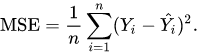

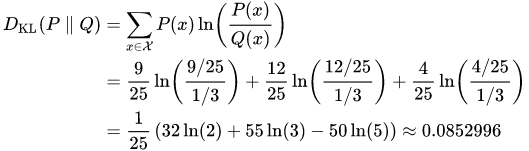

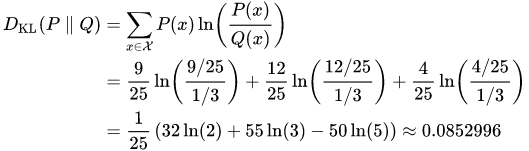


In [ ]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help


STEP 11 -  set compiolation parameters and compile VAE

In [ ]:
c = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

STEP 12 - Train the network.

In [ ]:
#epochs
e= 200
#batch_size
bs= 64
#normalize data
data= img_data.astype("float32")/255 

vae.fit(data,img_data,epochs=e, batch_size=bs)

STEP 13 - Plot image function 

In [ ]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*28, cols*28,3))
    for row in range(rows):
        for col in range(cols):
            grid[row*28:(row+1)*28, col*28:(col+1)*28, :] = images[row*cols + col]
       
    plt.figure(figsize=(40,40))  
    plt.imshow(grid,  interpolation='nearest')
    plt.title(title)
    plt.show()

STEP 14 - plot 200 original images

In [ ]:
predictions = data[:200]
plot_images(20,8,predictions,"ORIGINAL IMAGES")

STEP 15 - Plot 200 reconstructed images

In [ ]:
predictions  = vae.predict(data[:200])
plot_images(20,8,predictions, "RECONSTRUCTED IMAGES")

Step 16 - generate 200 new images

In [ ]:
predictions= decoder.predict(np.random.randn(200, latent_dims))
plot_images(20,8,predictions, "GENERATED IMAGES (NEW IMAGES)")

step 17 - Interpolate from a vector

In [ ]:
#set inerpolation step
step = 0.5
#generate a random vector
vec=np.random.randn(1, latent_dims)

#set number of predictions
nPredictions= 320

#counter 
c=0

for i in range (nPredictions):
  
  ivec= vec*c #add value to a vector

  prediction= decoder.predict(ivec)
  # Reshape the array into 28 x 28 array (2-dimensional array)
  pixels = prediction.reshape((28, 28))

  # Plot
  #plt.title('result')
  plt.imshow(pixels, cmap='gray')
  plt.axis('off')
  plt.show()
  c=c+step